# LL fit to uSEIR

## May 2020

In [1]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun May 24 17:53:05 2020


In [2]:
import numpy as np
import pandas as pd
import matplotlib

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
## mathplotlib configuration
fontsize = 12
plt.rcParams["figure.figsize"] = 6, 5
plt.rcParams["font.size"     ] = fontsize

#font = {'family': 'serif',
#        'color':  'black',
#        'weight': 'bold',
#        'size': fontsize,
#        }

plt.style.context('seaborn-colorblind');


In [5]:
import scipy.stats  as stats

from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d

In [6]:
import c19.cfit         as cfit

import c19.useir            as us
import c19.kfmysir          as kf

In [7]:
import c19.cfitsir      as cfsir

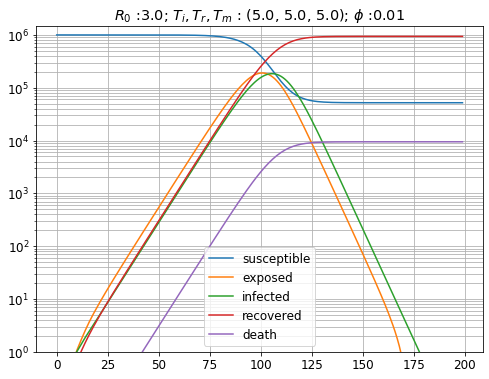

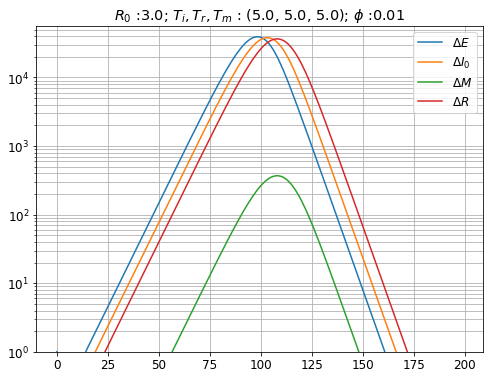

In [8]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 5.
PhiM            = 0.01
ndays           = 200
rho             = 'gamma'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

### Generate random data

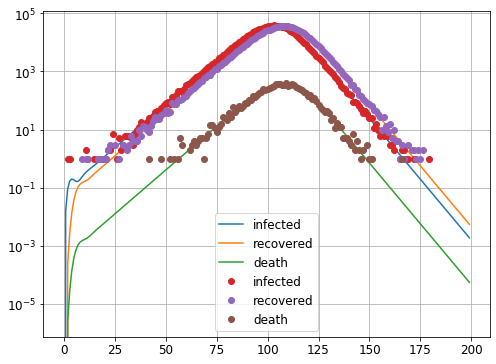

In [9]:
DS = DI0, DR, DM
ds = us.useir_rvdata(DI0, DR, DM)
us.plt_useir_rvdata(ts, DS, ds);
plt.yscale('log');

In [10]:
## LLFit

### Initial conditions

### Test 

In [11]:
pars = (R0, TR)
dms = us._useir(pars)

In [12]:
irv = us.useir_rv(dms)

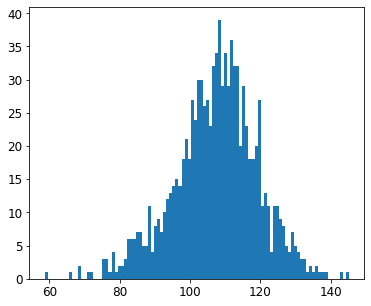

In [13]:
times= irv.rvs(size = 1000)

plt.hist(times, 100);

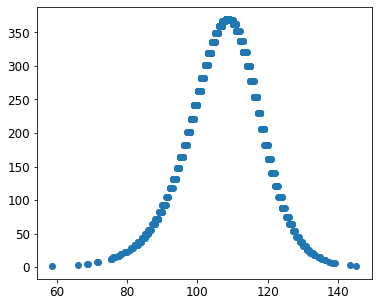

In [14]:
plt.scatter(times, us.useir_fun(times, pars))

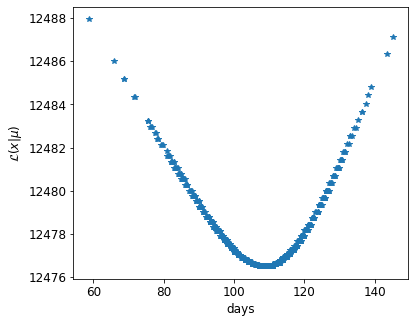

In [15]:
ll = -2 * us.useir_llike(times, pars)
plt.plot(times , ll, marker = '*', ls = '');
plt.xlabel('days'); plt.ylabel(r'$\mathcal{L}(x | \mu)$');

### Test one experiment

- Fixed parameters: $N, t_i, t_r$.
- Free paramter   : $R_0$
- size            : $n_0$ infected individuals

size  9479.792182345229


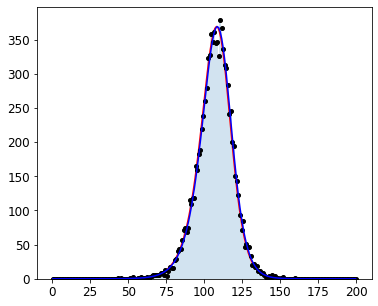

In [16]:
r0, ti, tr     = R0, TI, TR

pars     = (r0, tr)
parsmask = (True, True)
dms = us._useir(pars)
nts = len(dms)
rv  = us.useir_rv(dms)
ts   = np.arange(len(dms))
size = np.sum(dms)
plt.plot(ts, dms, c = 'red');
print('size ', size)

xs = rv.rvs(size = int(size))
#print(times)
#phat_mle = cfit.mle(times, us.useir_llike, useir_pars, useir_parsmask)
nbins   = len(dms)
ys, xxs = np.histogram(xs, nbins, (0, nbins))
xxs   = 0.5*(xxs[1:] + xxs[:-1])
plt.hist(xs, nts, (0, nts), alpha = 0.2);
plt.plot(xxs, ys, ls = '', marker = 'o', ms = 4, c = 'black'); plt.yscale('linear')
plt.plot(xxs, us.useir_fun(xxs, pars), c = 'blue', ls = '-');
#phat_lsq = cfit.lsq(xxs, ys, us.useir_fun, pars, parsmask)

In [17]:
def useir_experiment(pars, ufun = us._useir):
    dms = ufun(pars)
    rv  = us.useir_rv(dms)
    size = np.sum(dms)
    xs = rv.rvs(size = int(size))
    return xs, dms

def mlefit(xs, pars, parmask, ufun = us._useir):
    llfun = lambda xs, pars: us.useir_llike(xs, pars, ufun)
    phat = cfit.mle(xs, llfun, pars, parsmask) 
    return phat

def lsqfit(xs, pars, parmask, ufun = us._useir, nbins = 200):
    lsqfun   = lambda xs, pars: us.useir_fun(xs, pars, ufun)
    ys, xxs = np.histogram(xs, nbins, (0, nbins))
    xxs = 0.5*(xxs[1:] + xxs[:-1])
    phat = cfit.lsq(xxs, ys, lsqfun, pars, parsmask)
    return phat
#    return times, phat_mle

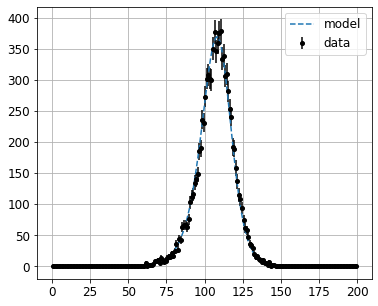

In [18]:
pars     = (R0, TR)
parsmask = (True, True)

xs, dms = useir_experiment(pars)
nbins   = len(dms)
ts      = np.arange(nbins)
plt.plot(ts, dms, ls = '--', label = 'model');
#print('events ', xs)
ys, xxs = np.histogram(xs, nbins, (0, nbins))
xxs = 0.5*(xxs[1:] + xxs[:-1])
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.legend(); plt.grid(which = 'both'); plt.yscale('linear')

(3.0, 5.0)
2.998752093154074 4.992101196301052


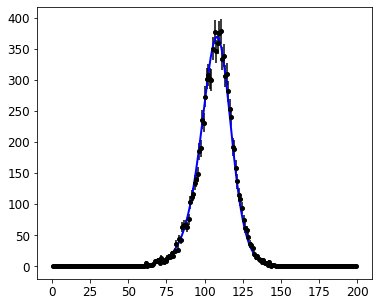

In [20]:
print(pars)
phat = mlefit(xs, pars, parsmask)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir_fun(ts, phat), c= 'blue', lw = 2);
print(*phat)

2.948405323059304 4.765344088441612


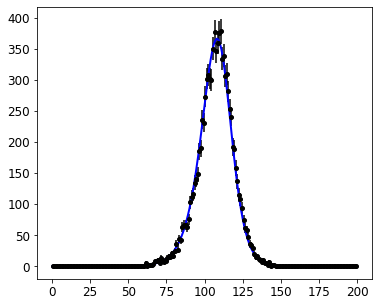

In [21]:
phat2 = lsqfit(xs, pars, parsmask)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir_fun(ts, phat2), c= 'blue', lw = 2);
print(*phat2)

### Change model to useir-quenched

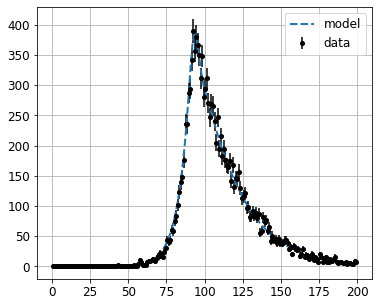

In [22]:
R1         = 0.8
r0, r1, tr = R0, R1, TR

pars     = (r0, r1, tr)
parsmask = (True, True, True)

xs, dms = useir_experiment(pars, ufun = us._useirvar)
nbins   = len(dms)
ts      = np.arange(nbins)
plt.plot(ts, dms, ls = '--', lw = 2, label = 'model');
#print('events ', xs)
ys, xxs = np.histogram(xs, nbins, (0, nbins))
xxs = 0.5*(xxs[1:] + xxs[:-1])
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.legend(); plt.grid(which = 'both'); plt.yscale('linear')

(3.0, 0.8, 5.0)
(True, True, True)
2.9746607806638687 0.8027938002832611 4.871291339833026


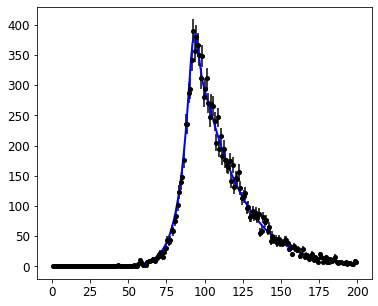

In [23]:
print(pars)
print(parsmask)
phat = mlefit(xs, pars, parsmask, ufun = us._useirvar)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir_fun(ts, phat, us._useirvar), c= 'blue', lw = 2);
print(*phat)

2.9426599786966827 0.8082621875297238 4.706095222876266


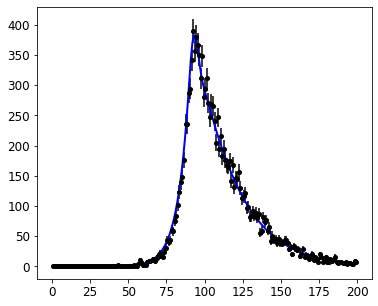

In [24]:
phat2 = lsqfit(xs, pars, parsmask, us._useirvar)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir_fun(ts, phat2, us._useirvar), c= 'blue', lw = 2);
print(*phat2)

## Example of uSEIR quenched with floating t0

In [31]:
def mlefit0(xs, pars, parmask, ufun = us._useir):
    llfun = lambda xs, pars: us.useir0_llike(xs, pars, ufun)
    phat = cfit.mle(xs, llfun, pars, parsmask) 
    return phat

def lsqfit0(xs, pars, parmask, ufun = us._useir, nbins = 200):
    lsqfun   = lambda xs, pars: us.useir0_fun(xs, pars, ufun)
    ys, xxs = np.histogram(xs, nbins, (0, nbins))
    xxs = 0.5*(xxs[1:] + xxs[:-1])
    phat = cfit.lsq(xxs, ys, lsqfun, pars, parsmask)
    return phat

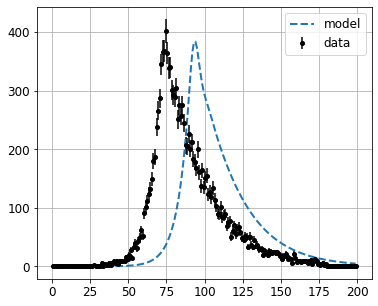

In [32]:
t0         = 20
R1         = 0.8
r0, r1, tr = R0, R1, TR

x0s, dms = useir_experiment(pars, ufun = us._useirvar)
xs       = x0s - t0
nbins    = len(dms)
ts       = np.arange(nbins)

plt.plot(ts, dms, ls = '--', lw = 2, label = 'model');
#print('events ', xs)
ys, xxs = np.histogram(xs, nbins, (0, nbins))
xxs = 0.5*(xxs[1:] + xxs[:-1])
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.legend(); plt.grid(which = 'both'); plt.yscale('linear')

19.991760984563786 2.9997178124920367 0.8013647232957601 5.0044563656447725


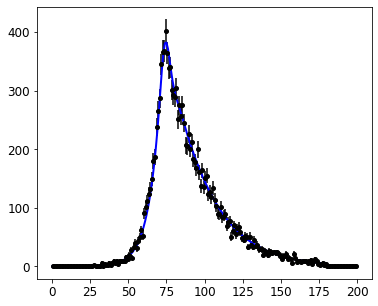

In [35]:
pars     = (t0, r0, r1, tr)
parsmask = (True, True, True, True)


phat = mlefit0(xs, pars, parsmask, ufun = us._useirvar)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir0_fun(ts, phat, us._useirvar), c= 'blue', lw = 2);
print(*phat)

20.20041190268607 2.981328843052288 0.804654105741875 4.91610387197902


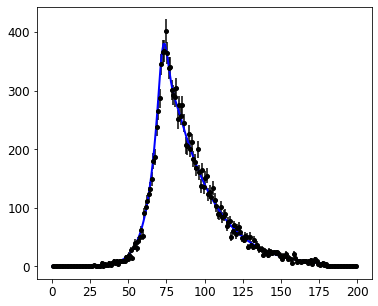

In [37]:
pars     = (t0, r0, r1, tr)
parsmask = (True, True, True, True)


phat2 = lsqfit0(xs, pars, parsmask, us._useirvar)
plt.errorbar(xxs, ys, yerr = np.sqrt(ys), c = 'black', 
             ls = '', marker = 'o', ms = 4, label = 'data');
plt.plot(ts, us.useir0_fun(ts, phat2, us._useirvar), c= 'blue', lw = 2);
print(*phat2)

In [ ]:
###---- Here we are